**Objective**: Build an XGBoost model for predicting heart disease and experiment with hyperparameter tuning to improve its performance.

Dataset: [Heart Disease UCI](https://archive.ics.uci.edu/dataset/45/heart+disease)

# Task 1: Data Loading and Exploration
1. Load the Heart Disease UCI dataset.
2. Explore the dataset to understand its structure and features.
3. Split the data into training and testing sets.

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


#Importing the data and dividing it into features (X) and label (y)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]

data = pd.read_csv(url, names=column_names, na_values="?")
print(data.info())
X = data.drop('target', axis=1)
y = data['target']

# To show the imbalance of the class distribution
print(y.value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
None
target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64


In [23]:
#Spliting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (242, 13)
Testing set shape: (61, 13)


# Task 2: Data Preprocessing
1. Handle missing values if any.
2. Encode categorical variables using appropriate methods.
3. Standardize or normalize numerical features if necessary.

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

print("Summary of missing values of particular features:")
print(data.isnull().sum())

Summary of missing values of particular features:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [25]:
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

numerical_imputer = SimpleImputer(strategy="mean")
categorical_imputer = SimpleImputer(strategy="most_frequent")

X_train[numerical_features] = numerical_imputer.fit_transform(X_train[numerical_features])
X_test[numerical_features] = numerical_imputer.transform(X_test[numerical_features])

X_train[categorical_features] = categorical_imputer.fit_transform(X_train[categorical_features])
X_test[categorical_features] = categorical_imputer.transform(X_test[categorical_features])

print("Summary of missing values of particular features after imputation:")
print("-------TRAINING SET-------")
print(X_train.isnull().sum())
print("-------TESTING SET-------")
print(X_test.isnull().sum())



Summary of missing values of particular features after imputation:
-------TRAINING SET-------
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64
-------TESTING SET-------
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


In [26]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor.sparse_output_=False

print(f"Shape of training set before OneHotEncoding: {X_train.shape}")

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(f"Shape of training set after OneHotEncoding: {X_train.shape}")

Shape of training set before OneHotEncoding: (242, 13)
Shape of training set after OneHotEncoding: (242, 28)


# Task 3: Initial XGBoost Model
1. Build an initial XGBoost model using default hyperparameters.
2. Train the model on the training set and evaluate its performance on the testing set.
3. Note down the accuracy and any other relevant metrics.

In [27]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score

xgb_model = XGBClassifier(random_state=76)

xgb_model = xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)

accuracy_default = accuracy_score(y_test, predictions)
precision_default = precision_score(y_test, predictions, average='macro')

print(f"Accuracy of the default model: {accuracy_default}")
print(f"Precision of the default model: {precision_default}")

Accuracy of the default model: 0.5573770491803278
Precision of the default model: 0.18


# Task 4: Hyperparameter Tuning
1. Experiment with hyperparameter tuning to improve model performance.
2. Adjust hyperparameters such as learning_rate, n_estimators, max_depth, etc.
3. Use techniques like cross-validation to find optimal hyperparameters.
4. Train and evaluate the model with the tuned hyperparameters.

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.1, 0.2],
}

xgb_classifier  = XGBClassifier(random_state=76)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("-------BEST PARAMETERS-------")
print(grid_search.best_params_)


-------BEST PARAMETERS-------
{'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [29]:
xgb_model_tuned = grid_search.best_estimator_

#########################################################
# BARDH'S COMMENTS
# you don't need to fit the classifier again. 
# GridSearchCV returns the best estimator already trained
xgb_model_tuned.fit(X_train, y_train)
#########################################################
predictions_tuned = xgb_model_tuned.predict(X_test)

accuracy_tuned = accuracy_score(y_test, predictions_tuned)
precision_tuned = precision_score(y_test, predictions_tuned, average='macro')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print(f"Accuracy after hyperparameter tuning: {accuracy_tuned}")
print(f"Precison after hyperparameter tuning: {precision_tuned}")

Accuracy after hyperparameter tuning: 0.5901639344262295
Precison after hyperparameter tuning: 0.1855072463768116


# Task 5: Feature Importance
1. Explore feature importance using the **feature_importances_** attribute of the trained XGBoost model.
2. Identify the most important features for heart disease prediction.

Text(0.5, 1.0, 'Feature Importance')

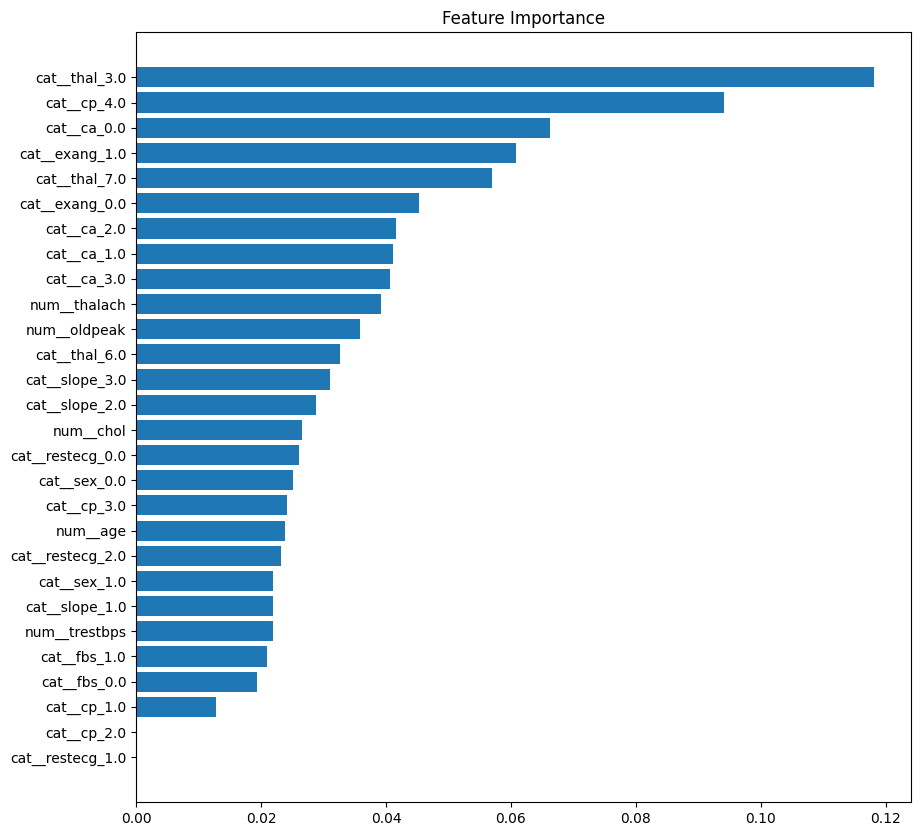

In [35]:
import matplotlib.pyplot as plt

feature_importance = xgb_model_tuned.feature_importances_

sorted_indices = np.argsort(feature_importance)

fig = plt.figure(figsize=(10,10))
plt.barh(range(len(sorted_indices)), feature_importance[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), np.array(X_test.columns)[sorted_indices])
plt.title('Feature Importance')


As we can see in the graph the most important features are:
- **thal_3.0** - A blood disorder called thalassemia - value 3 indicates normality
- **cat_cp_4.0** - Chest pain - value 4 indicates asymptomatic
- **cat_ca_0.0** - number of major vessels (0) colored by flourosopy
- **cat_exang_1.0** - exercise induced angina (1 = yes)
- **cat_thal_3.0** - A blood disorder called thalassemia - value 7 indicates  reversible defect

# Task 6: Model Evaluation
1. Compare the performance metrics of the initial model and the tuned model.
2. Visualize the improvement achieved in a clear and concise manner.
3. Discuss the impact of hyperparameter tuning and feature importance on model performance.

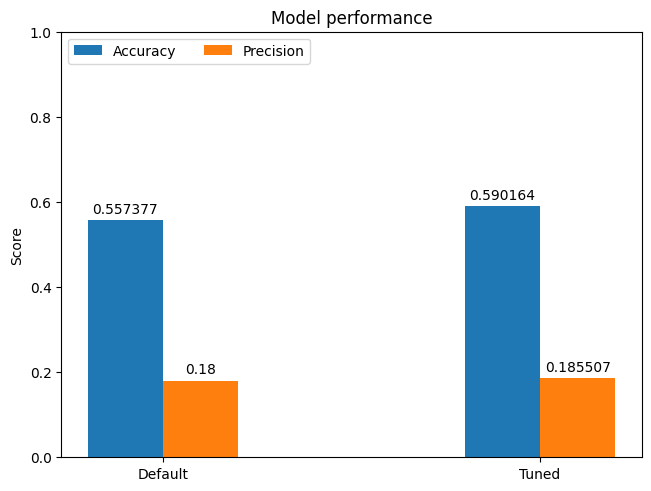

In [52]:
# import matplotlib.pyplot as plt
# import seaborn as sns

models = ("Default", "Tuned")
model_metrics = {
    'Accuracy': (accuracy_default, accuracy_tuned),
    'Precision': (precision_default, precision_tuned),
}

x = np.arange(len(models)) 
width = 0.2
multiplier = 0
fig, ax = plt.subplots(layout='constrained')

for metric, score in model_metrics.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, score, width, label=metric)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('Model performance')
ax.set_xticks(x + 0.5*width, models)
ax.legend(loc='upper left',ncol=2)
ax.set_ylim(0, 1)

plt.show()

As demonstrated above hyperparameter tuning can help in improving model performance (even though in this particular instance the improvment is not very significant). It is related to the structure of the dataset which is extremely imbalanced and therefore the model is biased to predict class 0 more often (the precision score is extremely low because of that). Some techniques for balancing the distribution of the classes should be used to improve the performance of the model.

When it comes to feature importance it is very important to perform feature selction so only the informative features influense the final prediction. In case of the used dataset it was already performed (in a way) by the scientific comunity -> only 14 out of 76 available attributes are included in the dataset.
